In [62]:
# Setting up
from __future__ import print_function, division
import os
import numpy as np
import torch
import pandas as pd
from skimage import io, transform

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from training_utils import *
from data_loading import *


transform_list = transforms.Compose([grey_world(),transforms.ToPILImage(),transforms.Scale(250),transforms.RandomHorizontalFlip() ,
                                     transforms.RandomCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


# transforms.RandomRotation(90, expand=True) and VerticalFlip() not working for some reason!!
input_dir= '../datasets/'
#input_dir = '/mnt/nfs/work1/lspector/aks/datasets/'

useSegmentation=False

train = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Training_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Training_Data/',segment_dir=input_dir+'ISIC-2017_Training_Part1_GroundTruth',useSegmentation = useSegmentation, transform=transform_list)

# Make a smaller training set for hyperparameter tuning. Use the first 1000 examples of original training set.
train_light = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Training_Part3_GroundTruth_light.csv',
                                    root_dir=input_dir+'ISIC-2017_Training_Data/',segment_dir=input_dir+'ISIC-2017_Training_Part1_GroundTruth',useSegmentation = useSegmentation, transform=transform_list)

validation  = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Validation_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Validation_Data/',segment_dir=input_dir+'ISIC-2017_Validation_Part1_GroundTruth', useSegmentation =useSegmentation,transform = transform_list)
test = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Test_v2_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Test_v2_Data/',segment_dir=input_dir+'ISIC-2017_Test_v2_Part1_GroundTruth', useSegmentation =useSegmentation,transform = transform_list)

train_data = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=1)
train_data_light = DataLoader(train_light, batch_size=8,
                        shuffle=True, num_workers=1)
val_data = DataLoader(validation, batch_size=8,
                        shuffle=True, num_workers=1)
test_data = DataLoader(test, batch_size=8,
                        shuffle=True, num_workers=1)

dataset_sizes = {'train':len(train),'val':len(validation),'test':len(test)}
print(dataset_sizes)

dataloaders = {'train':train_data,'val':val_data,'test':test_data}
%load_ext autoreload
%autoreload 2

{'test': 600, 'train': 2000, 'val': 150}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0 8
1 8
2 8


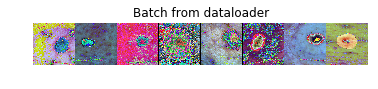

In [113]:
for i_batch, sample_batched in enumerate(test_data):
    print(i_batch, sample_batched['image'].shape[0])

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

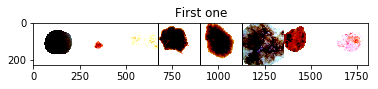

In [124]:
# visualizing some images
# Get a batch of training data
inputs = next(iter(train_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title="First one")

In [27]:
model_resnet = torchvision.models.resnet34(pretrained=True) #used resnet18 for baseline
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features

#print(num_ftrs)
model_resnet.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=1.13e-03, weight_decay = 5.37e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [3]:
model_vgg = torchvision.models.vgg19_bn(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_vgg.classifier[6].out_features#model_vgg.fc.in_features

#print(num_ftrs)
model_vgg.classifier.add_module("7",nn.ReLU())
model_vgg.classifier.add_module("8",nn.Linear(num_ftrs, 2))
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_vgg.classifier[8].parameters(), lr=0.001, weight_decay = 5.37e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [60]:
#Hyper-parameter tuning
from numpy.random import uniform

dataset_sizes1 = {'train':len(train_light),'val':len(validation),'test':len(test)}
print(dataset_sizes1)

dataloaders1 = {'train':train_data_light,'val':val_data,'test':test_data}

#for Resnet
maxcount = 10
for count in range(maxcount):
    reg = 10**uniform(-5, 0)
    lr = 10**uniform(-3,-5)
    optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=lr, weight_decay = reg, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model_conv = train_model(model_resnet, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders1,dataset_sizes1,num_epochs=2)
    print("reg: %.4e" %reg)
    print("lr: %.4e" %lr)
    print("--------------")
    print("")


{'test': 600, 'train': 1000, 'val': 150}
Epoch 0/1
----------
train Loss: 0.0624 Acc: 0.7980 AUC: 0.5153
val Loss: 0.0561 Acc: 0.8333 AUC: 0.5257

Epoch 1/1
----------
train Loss: 0.0577 Acc: 0.8030 AUC: 0.5497
val Loss: 0.0588 Acc: 0.8133 AUC: 0.5492

Training complete in 11m 59s
Best val Acc: 0.833333
reg: 1.1359e-03
lr: 5.3748e-04
--------------

Epoch 0/1
----------
train Loss: 0.0530 Acc: 0.8100 AUC: 0.5853
val Loss: 0.0604 Acc: 0.8133 AUC: 0.5786

Epoch 1/1
----------
train Loss: 0.0507 Acc: 0.8210 AUC: 0.6013
val Loss: 0.0604 Acc: 0.8000 AUC: 0.5979

Training complete in 12m 53s
Best val Acc: 0.813333
reg: 6.5358e-04
lr: 3.1171e-04
--------------

Epoch 0/1
----------
train Loss: 0.0565 Acc: 0.8120 AUC: 0.6122
val Loss: 0.0581 Acc: 0.7933 AUC: 0.6069

Epoch 1/1
----------
train Loss: 0.0540 Acc: 0.8270 AUC: 0.6363
val Loss: 0.0613 Acc: 0.8067 AUC: 0.6322

Training complete in 13m 5s
Best val Acc: 0.806667
reg: 5.2831e-03
lr: 9.8781e-04
--------------

Epoch 0/1
----------
train 

In [3]:
# Train a model
#model_conv = train_model(model_resnet, criterion, optimizer_conv,
#                         exp_lr_scheduler, dataloaders,dataset_sizes,num_epochs=5)


In [1]:
#test_model(model_conv, criterion, dataloaders1,dataset_sizes1)

In [5]:
print("Results using ensamble learning")

models_dir = '../models/'
#models_dir = input_dir
model_state_list = None
num_epochs = 5
model= model_resnet#, model_vgg
model_num = 1 # 1 for resnet
#models_list = train_model_epochs(model, model_num,models_dir,criterion, optimizer_conv,
#                                      exp_lr_scheduler, dataloaders,dataset_sizes,num_epochs=num_epochs)

Results using ensamble learning


In [4]:
# Simple ensamle
#acc = test_ensamble_model(model_resnet, model_vgg,dataloaders, dataset_sizes, models_dir, ([1],1, num_epochs))
#print(acc)

In [5]:
# Ensamble using SVM 

#print("Results using Meta-model :resnet + vgg")
#clf = train_meta_model(model_resnet, model_vgg, dataloaders, dataset_sizes, models_dir, ([0,1],1, num_epochs))

In [6]:
#acc = test_meta_model(model_resnet, model_vgg, dataloaders, dataset_sizes, models_dir,([0,1],1, num_epochs), clf)
#print(acc)